In [1]:
%matplotlib inline
# %load_ext autoreload
# %autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('notebook', font_scale=1.3)
sns.set_style('white')

In [2]:
from mouselab import *
from distributions import *
from bayes_q import *
from gymrats.core import Agent
from exact import solve
from skopt import gp_minimize
from skopt.space import Real,Space

from joblib import Parallel, delayed, load, dump

/usr/local/lib/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
cost_range = [0,0.3]
branch_range = [2,4]
height_range = [2,4]
reward_alpha = 1

In [4]:
def get_optimal_return(env):
    q, v, pi, info = solve(env)
    return v(env.init)

def sample_env():
    cost = np.random.uniform(*cost_range)
    branch = np.random.randint(*branch_range)
    height = np.random.randint(*height_range)
    R = Categorical([-1, 0, 1],np.random.dirichlet(np.ones(3)*reward_alpha))
    return MouselabEnv(branch, height, reward=R, cost=cost)

In [5]:
import random

def create_training_df(env, prior_params, n_episode):
    policy = BayesianQLearner(5, prior_params=prior_params)
    agent = Agent(env, policy)
    return pd.DataFrame(agent.run_many(n_episode, pbar=False))

def make_prior_params(x):
    if len(x) == 5:  # no learning
        return np.r_[x[:5], np.ones(5) * 1e10, 1, 1]
    else:
        assert len(x) == 12
        return x

def training_return(x, seed=None, n_episode=20):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    df = create_training_df(sample_env(), make_prior_params(x), n_episode)
    return np.mean(df.return_.values)

# def global_training_objective_single(x):
#     prior_params = np.r_[x[:5], np.ones(5) * 1e10, x[5:]]
#     df = create_training_df(sample_env(), prior_params, n_episode)
#     return np.mean(df.return_.values)

def make_objective(single, N, parallel=True, **kwargs):
    def objective(x):
        if parallel:
            jobs = (delayed(single)(x, np.random.randint(100000000), **kwargs) for _ in range(N))
            returns = Parallel(-1, backend='multiprocessing')(jobs)
        else:
            returns = [single(x, **kwargs) for _ in range(N)]
        y = np.mean(returns)
        print(objective.counter, np.round(y, 3), np.round(x,2))
        objective.counter += 1
        return y
    objective.counter = 0
    return objective

In [6]:
%time make_objective(training_return, N=100, n_episode=50)(np.ones(5))

0 -0.047 [1. 1. 1. 1. 1.]
CPU times: user 205 ms, sys: 51.9 ms, total: 257 ms
Wall time: 2min 27s


-0.046780435762877486

In [13]:
def train_agent(kind, n_iter=200, n_env=100, n_episode=25, **kwargs):
    dimensions = [Real(1, 20), Real(0,1), Real(0,1), Real(0,1), Real(0,2)]
    if kind == 'meta':
        dimensions.extend([Real(0.1,100)]*5 + [Real(0.1,20)] + [Real(0.1,10)])
    print(len(dimensions))
        
    objective = make_objective(training_return, N=n_env, n_episode=n_episode)
    return gp_minimize(lambda x: - objective(x),
                       dimensions=dimensions, n_calls=n_iter, **kwargs)

In [10]:
# x = global_res.x
# dump(global_res.x, 'pickle/global_x')
global_x = load('pickle/global_x')

In [13]:
%%time
def training_returns(env, prior):
    return list(create_training_df(env, prior, 25).return_)

env = sample_env()
precision = 1e10
prior = np.r_[global_x, np.ones(5) * precision, 1, 1]


CPU times: user 2.46 s, sys: 40.6 ms, total: 2.5 s
Wall time: 2.54 s


0    -0.487059
1     1.332702
2     0.627835
3    -0.182133
4     0.932760
5     0.275255
6     0.780297
7     1.180239
8    -0.124686
9     1.180239
10   -0.277149
11    0.085223
12    0.322909
13   -0.029670
14    1.332702
15    0.570388
16   -0.677091
17    0.932760
18    1.390149
19    0.875314
20    0.275255
21    1.322909
22    1.390149
23    0.237686
24    1.485165
Name: return_, dtype: float64

In [30]:
env = sample_env()
def job(env):
    return create_training_df(env, make_prior_params(x), 20).return_

res = Parallel(-1)(delayed(job)() for _ in range(48))

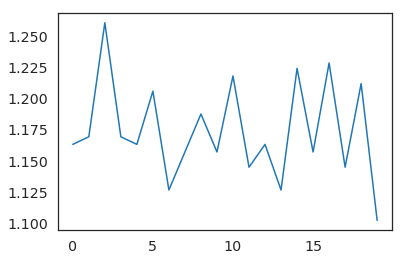

In [46]:
plt.plot(np.mean(np.stack(res), 0))

In [ ]:
global_res = train_agent('global', n_iter=100)
# meta_res = train_agent('meta', n_iter=100, )

5
0 0.41 [12.37  0.02  0.48  0.75  1.39]
1 0.031 [16.64  0.1   0.05  0.32  0.91]
2 0.163 [5.24 0.06 0.15 0.25 1.2 ]
3 0.091 [19.07  0.65  0.38  0.34  1.65]
4 0.294 [3.71 0.26 0.85 0.06 1.96]
5 0.427 [17.81  0.51  0.76  0.63  0.45]
6 0.007 [17.38  0.22  0.71  0.43  0.53]
7 0.206 [13.43  0.9   0.27  0.88  0.99]
8 0.42 [1.57 0.49 0.48 0.73 1.06]
9 0.396 [5.03 0.23 0.29 0.11 0.38]
10 0.547 [5.85 0.71 0.21 0.65 2.  ]
11 0.285 [20.   0.   0.   0.6  2. ]
12 0.233 [17.23  1.    0.12  0.69  1.3 ]
13 0.392 [4.06 0.6  0.35 0.65 1.97]
14 0.363 [5.29 0.   0.17 0.91 1.92]
15 0.485 [3.06 0.34 0.02 0.69 1.98]
16 -0.11 [20.    1.    0.06  0.    0.53]


In [18]:
global_res.x

[5.1900747666740665, 1.0, 0.0, 0.7608941230617052, 1.5964623242530707]

In [21]:
from skopt import expected_minimum

def choose_x(res):
    objective = make_objective(training_return, N=1000)
    x_exp, f_exp_pred = expected_minimum(res)
    f_exp = objective(x_exp)
    x_emp, f_emp_pred = res.x, res.fun
    f_emp = objective(x_emp)
    print(f'Expected: {np.round(x_exp, 2)}  ->  {f_exp:.3f}  ({-f_exp_pred:.3f})')
    print(f'Empirical: {np.round(x_emp, 2)}  ->  {f_emp:.3f}  ({-f_emp_pred:.3f})')
    return x_exp if f_exp > f_emp else x_emp
    
x_meta = choose_x(meta_res)

0 0.531 [  3.82   1.     1.     0.54   2.    99.78  64.76 100.    56.91  95.44   8.91   0.1 ]
1 0.507 [  1.     0.58   0.98   0.53   0.27  78.82 100.    17.65   5.28  35.37  19.59   1.59]
Expected: [  3.82   1.     1.     0.54   2.    99.78  64.76 100.    56.91  95.44   8.91   0.1 ]  ->  0.531  (0.541)
Empirical: [  1.     0.58   0.98   0.53   0.27  78.82 100.    17.65   5.28  35.37  19.59   1.59]  ->  0.507  (0.757)


In [53]:
# from skopt import expected_minimum
# x_global, f_global = expected_minimum(global_res)
# print(np.round(x_global, 3))

# prm = make_prior_params(x_global)
# f_emp = make_objective(training_return, N=1000)(prm)
# print(f'Expected: {-f_global:.3f}')
# print(f'Empirical: {f_emp:.3f}')

# prm_100 = make_prior_params(x_global)
# prm_100[5:10] = 100
# f_100 = make_objective(training_return, N=1000)(prm_100)

# print(f'100: {f_100}')

# meta_res = train_agent('meta', n_iter=200, x0=[prm_100.tolist()], y0=[f_100])

/usr/people/flc2/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:683: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/people/flc2/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:683: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/people/flc2/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:683: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0 0.55 [4.51e+00 1.00e+00 6.10e-01 5.00e-01 2.00e+00 1.00e+10 1.00e+10 1.00e+10 1.00e+10 1.00e+10 1.00e+00 1.00e+00]
Expected: -0.549
Empirical: 0.550


/usr/people/flc2/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:683: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/people/flc2/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:683: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/people/flc2/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:683: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/people/flc2/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:683: UserWarning: A wor

0 0.508 [  4.51   1.     0.61   0.5    2.   100.   100.   100.   100.   100.     1.     1.  ]
100: 0.5079569035419126


In [54]:
from tqdm import tqdm

def train(env, prior_params, n_episode, seed):
    np.random.seed(seed)
    random.seed(seed)
    df = create_training_df(env, prior_params, n_episode)
    return df.return_


def train_many(envs, x, n_episode=20):
    prior_params = make_prior_params(x)
    jobs = (delayed(train)(env, prior_params, n_episode, np.random.randint(10000000)) for env in envs)
    return Parallel(-1)((jobs))

x_baseline = list(np.r_[np.zeros(5), np.ones(5)*.01, 1,.1])
num_replications = 1000
envs = [sample_env() for _ in range(num_replications)]
# %time global_returns = train_many(envs, x_global)
%time meta_returns = train_many(envs, x_meta)
%time baseline_returns = train_many(envs, x_baseline)

CPU times: user 2.18 s, sys: 200 ms, total: 2.38 s
Wall time: 9.7 s


Text(0,0.5,'Return')

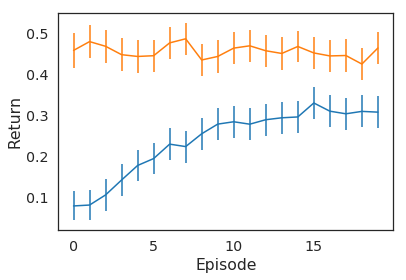

In [58]:
def plot_returns(X, **kwargs):
    plt.errorbar(x=np.arange(X.shape[1]),y=np.mean(X,axis=0),
             yerr=np.std(X,axis=0)/np.sqrt(X.shape[0]), **kwargs)
    
# plot_returns(np.stack(global_returns), label='Global')
plot_returns(np.stack(baseline_returns), label='Baseline')
plot_returns(np.stack(meta_returns), label='Meta')
plt.xlabel("Episode")
plt.ylabel("Return")

/usr/people/flc2/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


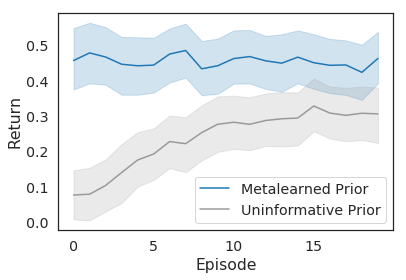

In [98]:

m = pd.melt(pd.DataFrame(np.stack(meta_returns)), var_name='Episode', value_name='Return')
sns.lineplot(m.Episode, m.Return)

n = pd.melt(pd.DataFrame(np.stack(baseline_returns)), var_name='Episode', value_name='Return')
sns.lineplot(n.Episode, n.Return, color=(0.6, 0.6, 0.6))


plt.legend(['Metalearned Prior', 'Uninformative Prior'], loc='lower right')
plt.savefig('figs/results.pdf',  pad_inches=0.1, bbox_inches='tight')

In [137]:
plt.errorbar(x=np.arange(global_returns.shape[1]),y=np.mean(global_returns,axis=0),
             yerr=np.std(global_returns,axis=0)/np.sqrt(global_returns.shape[0]),label='mean return of learned policy')
plt.errorbar(x=np.arange(meta_returns.shape[1]),y=np.mean(meta_returns,axis=0),
             yerr=np.std(meta_returns,axis=0)/np.sqrt(meta_returns.shape[0]),label='mean return of meta-learned policy')
#plt.errorbar(np.mean(returns_meta,axis=0),'.-',label='mean return of meta-learned policy')
#plt.plot(pd.DataFrame(np.mean(returns,axis=0)).rolling(10).mean(),'.-',label='mean return of learned policy')
#plt.axhline(np.mean(optimal_return),color='black',linestyle='dashed',label='return of optimal policy')
plt.legend(frameon=False)

plt.show()

#plt.show()
#df.n_steps.rolling(1).mean().plot()
#plt.show()

AttributeError: 'list' object has no attribute 'shape'

In [145]:
np.savetxt('returns_notmeta.txt',returns)
np.savetxt('returns_meta.txt',returns_meta)

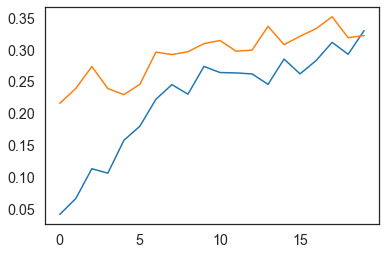

In [149]:
x = np.loadtxt('returns_notmeta.txt')
y = np.loadtxt('returns_meta.txt')
plt.plot(np.mean(x,axis=0))
plt.plot(np.mean(y,axis=0))